In [1]:
%pylab inline
# Import solar abundances
import os
FS=16
os.chdir('/home/oliverphilcox/ChempyMulti/')
tng=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG_galaxy_all.npz")

Populating the interactive namespace from numpy and matplotlib


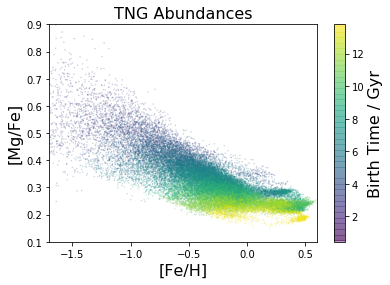

In [2]:
MgFeTNG=tng.f.abundance[:,3]
HeFeTNG=tng.f.abundance[:,2]
FeHTNG=tng.f.abundance[:,1]
timesTNG=tng.f.birth_time
plt.scatter(FeHTNG,MgFeTNG,alpha=0.4,s=0.1,c=timesTNG)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('TNG Abundances',fontsize=FS);
plt.xlim([-1.7,0.6]);plt.ylim([0.1,0.9]);

### Make some Chempy data:

In [22]:
from Chempy.parameter import ModelParameters
a=ModelParameters()
import multiprocessing as mp
import numpy as np
import tqdm, time
from scipy.stats import norm,uniform
from Chempy.cem_function import single_timestep_chempy

N_samples = 1000
widths = [0.,0.,0.,0.3,0.1,0.1]
priors = [-2.3,-2.89,0.,-0.3,0.55,0.5]
all_params=np.zeros([N_samples,len(priors)+1])
for i in range(len(all_params)):
    while all_params[i,4]<0.29402: # to avoid SFR errors
        all_params[i,:6]=norm.rvs(loc=priors,scale=widths)
    all_params[i,6]=uniform.rvs(loc=1.0,scale=12.8)
print("Created %d-element parameter set."%N_samples)

def runner(index):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    params=all_params[index]
    output=single_timestep_chempy((params,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(els)),params
    else: 
        abun=output[0]
        del b;
        outs=abun,params
    return outs

init_time=time.time()
    
# Compute elements by running code once:
output=single_timestep_chempy((list(priors)+[10.],a))
if output==np.inf:
    raise Exception("Bad SFR input even for prior parameters - check for bugs")
else:
    _,els=output

# Now run multiprocessing
cpus=mp.cpu_count()
p=mp.Pool(min(16,cpus))
output=list(tqdm.tqdm(p.imap_unordered(runner,range(N_samples)),total=N_samples))
abuns=[o[0] for o in output]
pars=[o[1] for o in output]

end_time=time.time()

print("multiprocessing complete after %d seconds"%(end_time-init_time));


Created 1000-element parameter set.


/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']
100%|██████████| 1000/1000 [00:30<00:00, 32.49it/s]

multiprocessing complete after 31 seconds


(array([0.00641488, 0.02407905, 0.06321912, 0.07801984, 0.11197222,
        0.11918664, 0.09096116, 0.09112851, 0.10767704, 0.05622783]),
 array([ 0.44178323,  1.77709942,  3.11241561,  4.44773179,  5.78304798,
         7.11836417,  8.45368036,  9.78899654, 11.12431273, 12.45962892,
        13.79494511]),
 <a list of 10 Patch objects>)

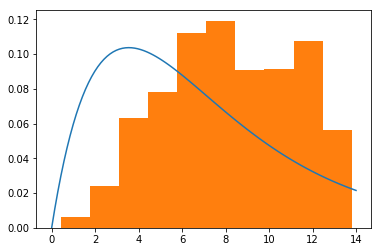

In [23]:
from scipy.special import gamma
def sfr(t,theta,k=2.):
    return t**(k-1.)/(gamma(k)*theta**k)*np.exp(-t/theta)
ts = np.linspace(0,14,100)
plt.plot(ts,sfr(ts,a.sfr_scale))
plt.hist(timesTNG,density=True)

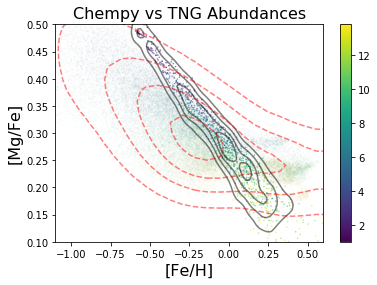

In [24]:
abuns = np.asarray(abuns)
pars = np.asarray(pars)
MgFeChempy=abuns[:,4]
HeFeChempy=abuns[:,3]#[:,4]
FeHChempy=abuns[:,1]
timesChempy=pars[:,-1]
plt.scatter(FeHTNG,MgFeTNG,alpha=0.04,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,MgFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.5},plot_density=False)
cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

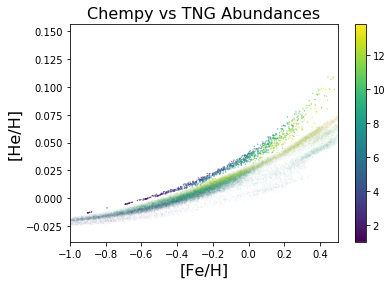

In [39]:
plt.scatter(FeHTNG,FeHTNG+HeFeTNG,alpha=0.04,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,FeHChempy+HeFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/H]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1,0.5]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

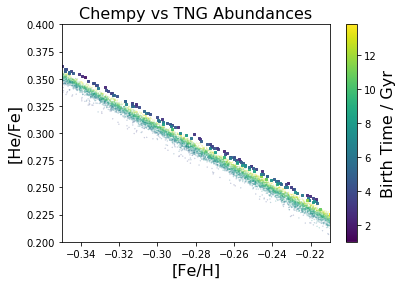

In [46]:
plt.scatter(FeHTNG,HeFeTNG,alpha=0.4,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,HeFeChempy,alpha=0.94,s=4,marker='s',c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

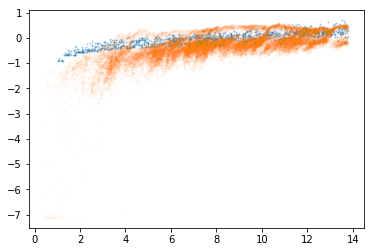

In [26]:
plt.scatter(timesChempy,FeHChempy,alpha=0.3,s=1)
plt.scatter(timesTNG,FeHTNG,alpha=0.03,s=1)

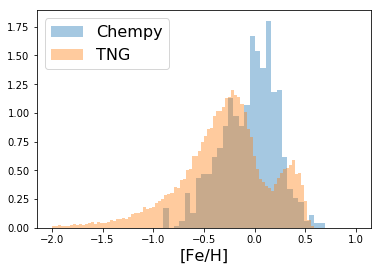

In [47]:
plt.hist(FeHChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(FeHTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS);

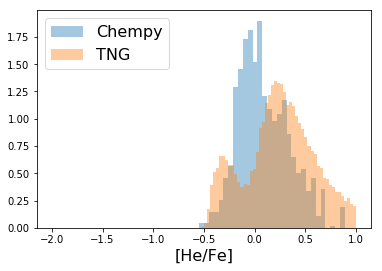

In [48]:
HeFeChempy=abuns[:,3]
plt.hist(HeFeChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(HeFeTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[He/Fe]',fontsize=FS);plt.legend(fontsize=FS);

## Check HDF5 files

In [214]:
import h5py
file=h5py.File('Chempy/input/yields/TNG/SNII.hdf5')
list(file.keys())

file['Metallicities'].value

x=file['Yields']['Z_0.00']['Yield']

yields=file['Yields/Z_0.00/Yield'].value

['Masses',
 'Metallicities',
 'Number_of_masses',
 'Number_of_metallicities',
 'Number_of_species',
 'Reference',
 'Species_names',
 'Yield_names',
 'Yields']

In [256]:
file['Yields/Z_0.00']['Ejected_mass'].value

array([ 4.826783 ,  5.6431684,  8.089241 ,  8.657515 , 10.522303 ,
       13.076985 , 15.142041 , 18.797949 , 23.533358 , 32.104225 ,
       25.580933 , 58.175022 , 77.45127  ], dtype=float32)

In [ ]:
file.close()

## Create Plot of TNG yields to compare to TNG

In [137]:
# Load solar abundances
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = els

# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

list_of_metallicities = [0.02]#np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap

In [156]:
basic_ssp = SSP_wrap(a)
basic_ssp.calculate_feedback(0.02,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

In [174]:
agbs,sn1as,sn2s=[],[],[]
for el in els:
    agbs.append(np.sum(basic_ssp.agb_table[el][:343]))
    sn1as.append(np.sum(basic_ssp.sn1a_table[el][:343]))
    sn2s.append(np.sum(basic_ssp.sn2_table[el][:343]))

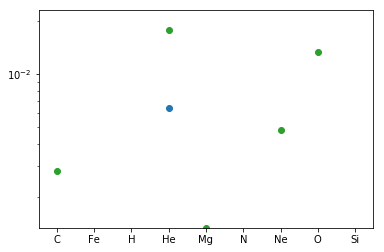

In [179]:
plt.scatter(els,agbs)
plt.scatter(els,sn1as)
plt.scatter(els,sn2s)
plt.yscale('log')

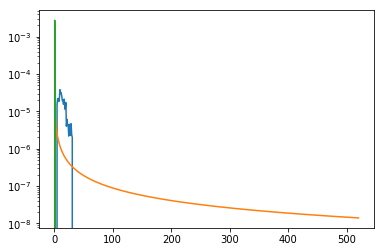

In [164]:
plt.plot(basic_ssp.agb_table['C'])
plt.plot(basic_ssp.sn1a_table['C'])
plt.plot(basic_ssp.sn2_table['C'])
plt.yscale('log')

In [138]:
def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [139]:
print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)


There are 40 CPUs on this machine


In [149]:
x = list_of_SSP_tables[2][0]

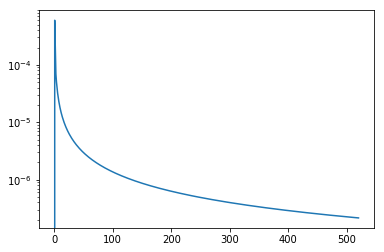

In [154]:
plt.plot(x['Fe'])
plt.yscale('log')

## Portinari Lifetimes

In [262]:
port_file = np.genfromtxt('portinari_ages.csv',skip_header=1)
port_Z = np.genfromtxt('portinari_ages.csv',max_rows=1)
port_M = port_file[:,0]
port_life = port_file[:,1:]

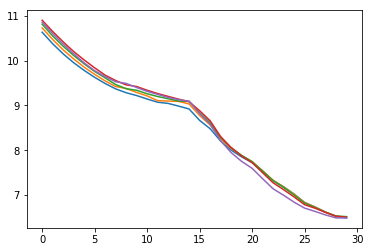

In [273]:
plt.plot(np.log10(port_life));#plt.colorbar()

In [282]:
def Argast_life(m,Z):
    lm = np.log10(m)
    a0 =  3.79 + 0.24*Z
    a1 = -3.10 - 0.35*Z
    a2 =  0.74 + 0.11*Z
    tmp = a0 + a1*lm + a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

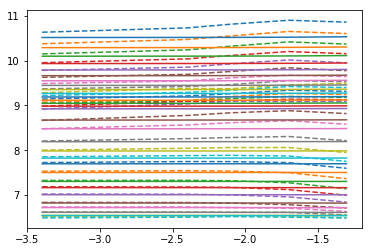

In [287]:
plt.plot(np.log10(port_Z),np.log10(port_life.T),ls='--')
for mi in port_M:
    plt.plot(np.log10(port_Z),np.log10(Argast_life(mi,port_Z)))